# Classifier

## Libraries

In [ ]:
import os                                              # Interact with the operating system
import random                                          # Ramdom numbers
import soundfile as sf                                 # Process audio files
import numpy     as np                                 # Mathemtical functions
import pandas    as pd
from matplotlib        import pyplot as plt            # Plot
from scipy.signal      import butter, lfilter, freqz   # Butterworth filter
from sklearn.externals import joblib                   # Import model
from playsound         import playsound                # Play songs
from scipy.spatial     import distance as dis          # Euclidean distance

General Characteristics

In [ ]:
genre   = {0:'Electronica',1:'Rap',2:'Rock',3:'Salsa'} # Dictionary to make predictions
fs      = 44100                                        # Standard sample frequency for all songs
[ti,tf] = [40,45]                                      # Standard Time segment to trim the songs
t       = np.arange(ti,tf,1/fs)                        # Time's vector for modulation and demodulation  
database=pd.read_csv('fft_Database.csv')               # Database in fft for euclidean distance

Butterworth low pass filter

In [ ]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a
def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

Read the song in .mp3 file and export 5 seconds of this in .wav file

In [ ]:
newsong='tabaco_ron'

<audio src='Modulation/rbc.mp3' controls>Your browser does not support the audio element.</audio>
[](--)

In [ ]:
mp3    = 'Modulation/'+newsong+'.mp3'
wav    = 'Modulation/'+newsong+'.wav'
os.system('ffmpeg -i ' + mp3 +' '+ wav)
xdat,a = sf.read(wav)
sf.write(wav, xdat[int(ti*fs):int(tf*fs),:], fs)
print('Sucsesful\n')

Sucsesful



<audio src='Modulation/tabaco_ron.wav' controls>Your browser does not support the audio element.</audio>
[](--)

Original song Spectrum

Text(0, 0.5, '$|X[n]|$')

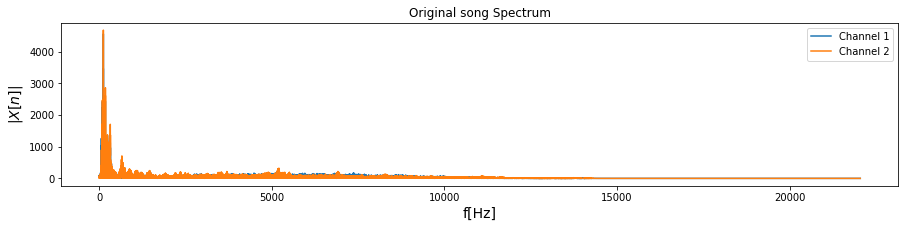

In [ ]:
song,a = sf.read(wav)
songw  = abs(np.fft.rfft(song,axis=0))
f      = np.fft.rfftfreq(np.size(song,axis=0), 1/fs)

plt.figure(figsize=[15,3])
plt.plot(f,songw)
plt.title('Original song Spectrum')
plt.legend(('Channel 1', 'Channel 2'))
plt.xlabel('f[Hz]',fontsize = 14)
plt.ylabel('$|X[n]|$',fontsize = 14)

## Modulation

Double Sideband with suppressed carrier Modulation

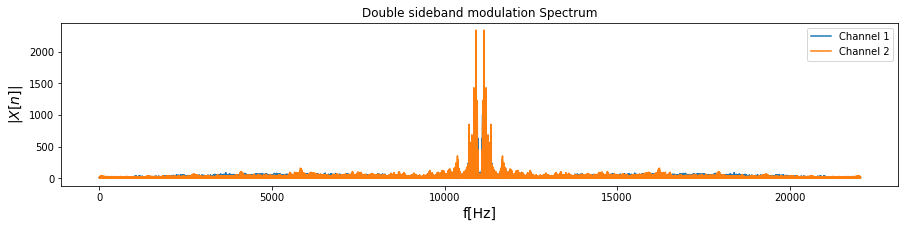

In [ ]:
fp = fs/4                                       # carrier signal frequency
wp = 2*np.pi*fp                                 # carrier signal angular velocity

# Modulate each channel separately
xdsb      = np.zeros([len(song[:,0]),2])
xdsb[:,0] = song[:,0]*np.cos(wp*t)            
xdsb[:,1] = song[:,1]*np.cos(wp*t)

Xdsbw     = abs(np.fft.rfft(xdsb, axis=0))      # Fourier Spectrum of modulation
f         = np.fft.rfftfreq(np.size(xdsb, axis=0), 1/fs)

plt.figure(figsize=[15,3])
plt.plot(f,Xdsbw)
plt.title('Double sideband modulation Spectrum')
plt.legend(('Channel 1', 'Channel 2'))
plt.xlabel(r'f[Hz]',fontsize = 14)
plt.ylabel(r'$|X[n]|$',fontsize = 14)
plt.show()

## Demodulation

Synchronous detection demodulation

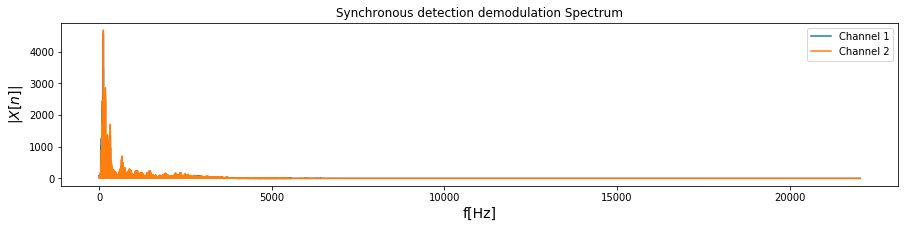

In [ ]:
# Demodulate each channel separately
ddsb      = np.zeros([len(xdsb[:,0]),2])
ddsb[:,0] = 2*butter_lowpass_filter(xdsb[:,0]*np.cos(wp*t), fp/4, fs)
ddsb[:,1] = 2*butter_lowpass_filter(xdsb[:,1]*np.cos(wp*t), fp/4, fs)

Ddsbw     = np.fft.rfft(ddsb, axis=0)  # Fourier Spectrum of demodulation
f         = np.fft.rfftfreq(np.size(ddsb, axis=0), 1/fs)
plt.figure(figsize=[15,3])
plt.plot(f,abs(Ddsbw))
plt.title('Synchronous detection demodulation Spectrum')
plt.legend(('Channel 1', 'Channel 2'))
plt.xlabel(r'f[Hz]',fontsize = 14)
plt.ylabel(r'$|X[n]|$',fontsize = 14)
plt.show()

Export the demodulation in .wav file 

In [ ]:
dem = 'Modulation/'+newsong + '_dem.wav'
sf.write(dem, ddsb, fs)
print('Sucsesful\n')

Sucsesful



<audio src='Modulation/tabaco_ron_dem.wav' controls>Your browser does not support the audio element.</audio>
[](--)

## Predict with the random forest model 

In [ ]:
x,a = sf.read(dem)                                  # Read the song after transmision
xsong=np.concatenate((x[:,0],x[:,1]),axis=None)     # Concatenate left and right channel
Xsongw=abs(np.fft.rfft(xsong))                      # Spectrum of concatenate song 
xpred=np.zeros((2,len(Xsongw)))                     # Song matrix with shape (2,data) for the prediction
xpred[0,:]=Xsongw
xpred[1,:]=Xsongw

In [ ]:
xpred

array([[9.97572327e+01, 5.96404685e+01, 6.22171191e+01, ...,
        1.32087913e-01, 3.67394988e-03, 1.38763428e-01],
       [9.97572327e+01, 5.96404685e+01, 6.22171191e+01, ...,
        1.32087913e-01, 3.67394988e-03, 1.38763428e-01]])

The genre of the song is: Rap 
Most similar song in Database: Track_19.wav


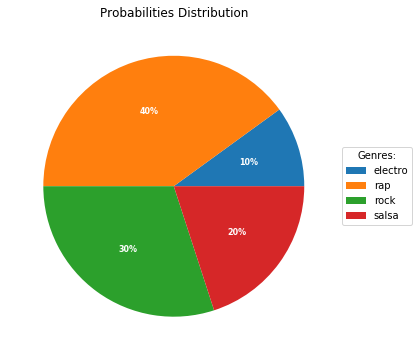

In [ ]:
rfc = joblib.load('RandomForest.pkl')               
prediction=int(rfc.predict(xpred)[0])   
ms=100000000000000000000
for i in range (40):
    if (prediction==0):j=i
    if (prediction==1):j=i+40
    if (prediction==2):j=i+80
    if (prediction==3):j=i+120
    dist=dis.euclidean(xpred[0,:],database.iloc[j,:])
    if (dist < ms):
        [ms,k]=[dist,i]
genres=['electro','rap','rock','salsa']
print('The genre of the song is: %s \nMost similar song in Database: %s'
      %(genre.get(prediction),'Track_'+str(k+1)+'.wav'))

#Probabilities Distribution
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.0f}%".format(pct, absolute)
data=rfc.predict_proba(xpred)[0,:]*100
wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))
ax.legend(wedges, genres,
          title="Genres:",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=8, weight="bold")
ax.set_title("Probabilities Distribution")
plt.show()

__Most similar song in Database__

<audio src='Database/rap/wavfiles/Track_19.wav' controls>Your browser does not support the audio element.</audio>
[](--)

In [ ]:
gen=np.zeros(np.size(database,axis=0))
for i in range(len(genre)):
    if i==1: gen[40:80]=1
    if i==2: gen[80:120]=2
    if i==1: gen[120:160]=3
gen

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3.])

In [ ]:
rfc.predict(database)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 3., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 3., 1., 2., 2., 2., 2., 2.,
       2., 2., 3., 2., 2., 2., 2., 2., 3., 0., 2., 2., 2., 2., 2., 3., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 0., 0., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3.])

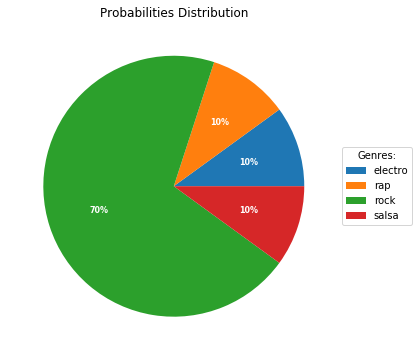

In [ ]:
#Probabilities Distribution
data=rfc.predict_proba(database.iloc[80:160,:])[0,:]*100

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.0f}%".format(pct, absolute)
wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))
ax.legend(wedges, genres,
          title="Genres:",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=8, weight="bold")
ax.set_title("Probabilities Distribution")
plt.show()